In [2]:
import pnet_loader
import sankey_diag
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
import Pnet_Regulatory2
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
datapath='/mnt/disks/pancan/data/'
rna, cna, tumor_type, mut = util.load_tcga_dataset(datapath+'brca_tcga_pan_can_atlas_2018', load_mut=True)
genetic_data = {'rna': rna}
target = pd.DataFrame(mut['PIK3CA']).astype(bool).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [12]:
canc_genes = list(pd.read_csv('../data/gene_sets/breast_gene_list.csv').values.reshape(-1))

In [15]:
target

,PIK3CA
Tumor_Sample_Barcode,
TCGA-3C-AAAU-01,0
TCGA-3C-AALI-01,0
TCGA-3C-AALJ-01,0
TCGA-3C-AALK-01,1
TCGA-4H-AAAK-01,0
...,...
TCGA-WT-AB44-01,0
TCGA-XX-A899-01,1
TCGA-XX-A89A-01,1


Task defined: BC 
 if this is not the intended task please specify task
Given 1 Input modalities
Found 1007 overlapping indicies
Initializing Train Dataset
Found 2116 overlapping genes
generated input DataFrame of size (906, 2116)
Initializing Test Dataset
Found 2116 overlapping genes
generated input DataFrame of size (101, 2116)
Found 2116 overlapping genes
Added extra layer
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 1 Input modalities
Found 1007 overlapping indicies
Initializing Train Dataset
Found 2116 overlapping genes
generated input DataFrame of size (906, 2116)
Initializing Test Dataset
Found 2116 overlapping genes
generated input DataFrame of size (101, 2116)
Found 2116 overlapping genes
Added extra layer
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 1 Input modalities
Found 1007 overlapping indicies
Initializin

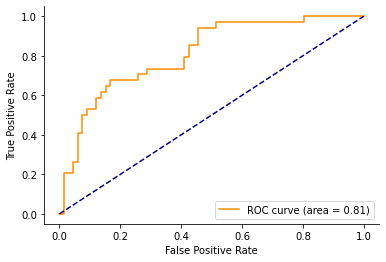

In [19]:
class_weights = util.get_class_weights(torch.tensor(target.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/breast_pik3ca/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/breast_pik3ca/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet_Regulatory2.run(genetic_data, target, seed=0,
                                                                                         dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/breast_pik3ca_reg/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet_Regulatory2.evaluate_interpret_save(model, test_dataset, '../results/breast_pik3ca_reg/run{}'.format(i))